In [1]:
from icevision.all import *
import pandas as pd

In [2]:
torch.cuda.is_available()

True

In [3]:
data_dir = Path('data')

In [4]:
data_dir.ls()

(#16) [Path('data/screen_4.png'),Path('data/screen_2.png'),Path('data/screen_1.png'),Path('data/camImage.csv'),Path('data/panels3D.csv'),Path('data/faultsScreen.csv'),Path('data/screen_5.png'),Path('data/screen_6.png'),Path('data/screen_3.png'),Path('data/screen_8.png')...]

In [5]:
faults_filepath = data_dir / 'faultsScreen.csv'
panels_filepath = data_dir / 'panelsScreen.csv'

In [25]:
faults_df = pd.read_csv(faults_filepath, names=['img', 'panel', 'x', 'y', 'camera_distance', 'severity'])

In [6]:
faults_df.head()

,img,panel,x,y,camera_distance,severity
0,0,1,855.9756,562.9597,5.856124,1.799800
1,0,1,1039.9300,395.7225,5.180756,2.672946
2,0,2,596.5045,417.9025,5.239655,1.682775
3,0,2,565.5096,452.0289,5.368117,3.571864
4,0,2,565.5358,393.3857,5.153532,1.959562


In [10]:
panels_df = pd.read_csv(panels_filepath, names=['img', 'panel', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])

In [11]:
panels_df.head()

,img,panel,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
0,0,0,1448.7830,302.3929,4.848379,1344.1570,565.2280,5.829680,1173.2190,304.6540,4.866513,1115.1590,566.2947,5.847815
1,0,1,1120.1490,307.8406,4.885396,1071.1520,568.1060,5.866697,847.8801,310.0645,4.903530,844.4354,569.1571,5.884832
2,0,2,790.6816,309.4182,4.865339,796.8146,570.3117,5.846640,518.5185,311.6453,4.883473,570.1711,571.3596,5.864774
3,0,3,469.0962,312.0494,4.886778,528.9846,571.5497,5.868079,199.3117,314.2570,4.904912,303.9917,572.5899,5.886213
4,1,0,1448.7830,302.3929,4.848379,1344.1570,565.2280,5.829680,1173.2190,304.6540,4.866513,1115.1590,566.2947,5.847815


In [23]:
imgs_filepaths = get_image_files(data_dir)

In [43]:
# keep only the rows that have images
imgs_idxs = [int(o.stem.split('_')[-1]) for o in imgs_filepaths]
faults_df = faults_df.loc[faults_df['img'].isin(imgs_idxs)]
panels_df = panels_df.loc[panels_df['img'].isin(imgs_idxs)]

In [44]:
class ScreenFaultParser(parsers.Parser, parsers.FilepathMixin, parsers.BBoxesMixin, parsers.LabelsMixin):
    def __init__(self, data_dir):
        faults_filepath = data_dir / 'faultsScreen.csv'
        
        self.data_dir = data_dir
        self.faults_df = pd.read_csv(faults_filepath, names=['img', 'panel', 'x', 'y', 'camera_distance', 'severity'])
        
    def __iter__(self) -> Any:
        # TODO: using global variable
        return faults_df.itertuples()
        
    def imageid(self, o) -> Hashable:
        return o.img
        
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o) -> Union[str, Path]:
        return self.data_dir / f'screen_{o.img}.png'
        
    def labels(self, o) -> List[int]:
        return [2]
    
    def bboxes(self, o) -> List[BBox]:
        x = o.x
        y = 908 - o.y
        return [BBox.from_xyxy(x-1, y-1, x+1, y+1)]

In [45]:
class PanelParser(parsers.Parser, parsers.FilepathMixin, parsers.BBoxesMixin, parsers.LabelsMixin):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        panels_filepath = data_dir / 'panelsScreen.csv'
        self.panels_df = pd.read_csv(panels_filepath, names=['img', 'panel', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
        
    def __iter__(self) -> Any:
        # TODO: using global variable
        yield from panels_df.itertuples()
        
    def imageid(self, o) -> Hashable:
        return o.img
        
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o) -> Union[str, Path]:
        return self.data_dir / f'screen_{o.img}.png'
        
    def labels(self, o) -> List[int]:
        return [1]
    
    def bboxes(self, o) -> List[BBox]:
        xs = (o.x1, o.x2, o.x3, o.x4)
        xmin, xmax = min(xs), max(xs)

        ys = 908 - np.array((o.y1, o.y2, o.y3, o.y4))
        ymin, ymax = min(ys), max(ys)
        
        return [BBox.from_xyxy(xmin, ymin, xmax, ymax)]

In [46]:
fault_parser = ScreenFaultParser(data_dir)
panel_parser = PanelParser(data_dir)

In [47]:
# fault_train_records, fault_valid_records = fault_parser.parse()
panel_train_records, panel_valid_records = panel_parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:124


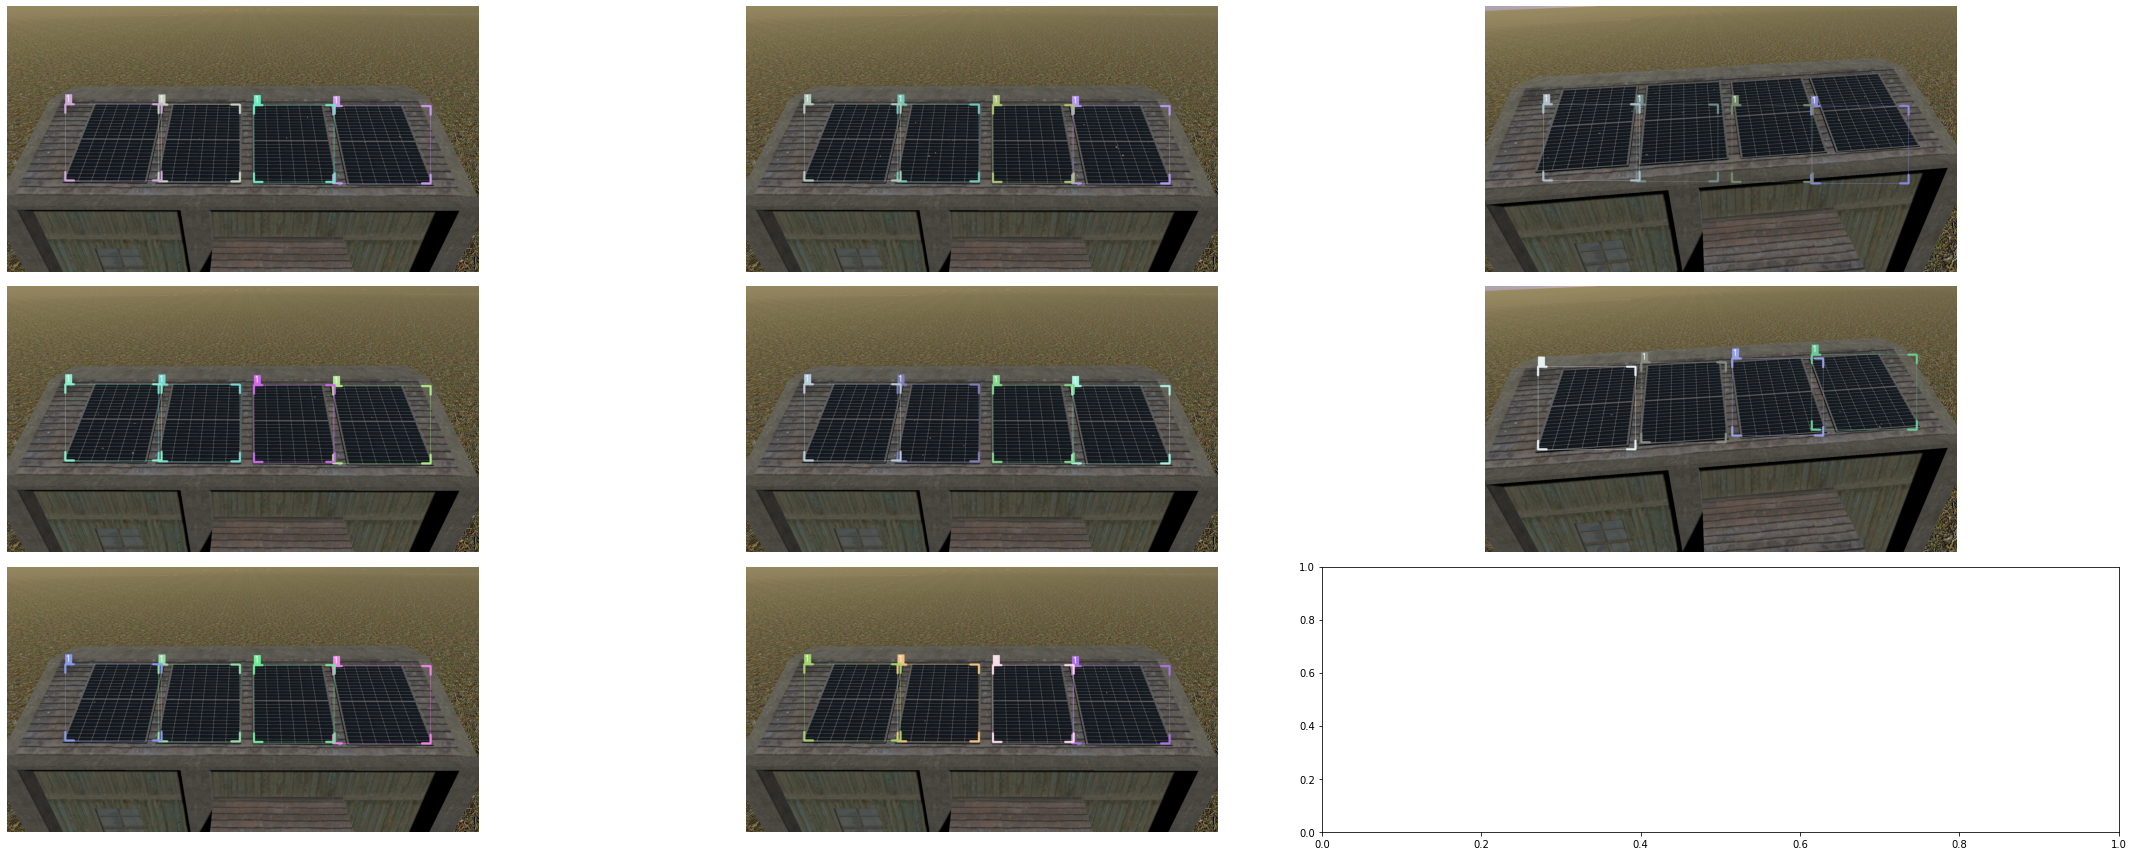

In [50]:
show_records(panel_train_records, ncols=3)

In [14]:
train_tfms = tfms.A.Adapter([tfms.A.LongestMaxSize(224), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.LongestMaxSize(224), tfms.A.Normalize()])

In [15]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [16]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=2, shuffle=True, num_workers=4)
valid_dl = faster_rcnn.valid_dl(train_ds, batch_size=2, shuffle=False, num_workers=4)

In [17]:
class_map = ClassMap(['fault'])

In [18]:
backbone = faster_rcnn.backbones.resnet_fpn.resnet18()
model = faster_rcnn.model(num_classes=len(class_map), backbone=backbone)

In [20]:
metrics = [COCOMetric(print_summary=False)]

In [21]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.00010964782268274575)

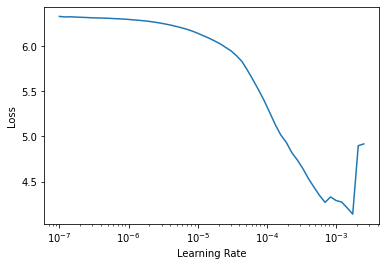

In [47]:
learn.lr_find()

In [22]:
learn.fine_tune(3, 1e-4)

epoch,train_loss,valid_loss,COCOMetric,time
0,6.079351,5.701794,0.000000,00:02


epoch,train_loss,valid_loss,COCOMetric,time
0,5.672146,5.607642,0.000000,00:02
1,5.610329,5.461084,0.000000,00:01
2,5.544662,5.410103,0.000000,00:02
